# 匯入套件

In [1]:
import tensorflow
if tensorflow.__version__.startswith('1.'):
    import tensorflow as tf
    from tensorflow.python.platform import gfile
else:
    import tensorflow as v2
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    import tensorflow.compat.v1.gfile as gfile
print("Tensorflow version:{}".format(tf.__version__))

Instructions for updating:
non-resource variables are not supported in the long term
Tensorflow version:2.5.0


In [3]:
import matplotlib.pyplot as plt
import os,cv2,shutil
import math,time
import numpy as np
import json

# DLIB初始化

In [4]:
import dlib
# ----Dlib init
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# 建立label轉換成類別名稱的字典集

In [5]:
label2classname_dict = {0:'no_mask',
                        1:"with_mask",
                        }

# 建立類別名稱轉換成label的字典集

In [6]:
classname2label_dict = {'no_mask':0,
                        "with_mask":1,
                        }

# 讀取訓練集路徑

In [17]:
train_img_dir = r"D:\dataset\face_mask\train_set"

train_paths = [file.path for file in os.scandir(train_img_dir) 
               if file.name.split(".")[-1] == 'png']

qty_train_path = len(train_paths)

train_paths = np.array(train_paths)

print("訓練集張數:",qty_train_path)

訓練集張數: 8903


# 讀取驗證集路徑 

In [11]:
test_img_dir = r"D:\dataset\face_mask\test_set"

test_paths = list()
label_test = list()

for dir_name,sub_dir_list,filename_list in os.walk(test_img_dir):
    if len(filename_list) > 0:
        classname = dir_name.split("\\")[-1]
        label = classname2label_dict[classname]
        
        for filename in filename_list:
            path = os.path.join(dir_name,filename)
            
            test_paths.append(path)
            label_test.append(label)
            
qty_test_path = len(test_paths)
#----串列轉換成 ndarray
test_paths = np.array(test_paths)
label_test = np.array(label_test)

print("test_paths shape:",test_paths.shape)
print("label_test shape:",label_test.shape)

print("驗證集張數:",qty_test_path)

test_paths shape: (25922,)
label_test shape: (25922,)
驗證集張數: 25922


# 讀取口罩PNG圖片集路徑

In [9]:
mask_img_dir = r"..\RGBA_PNG_masks"

mask_paths = [file.path for file in os.scandir(mask_img_dir) 
              if file.name.split(".")[-1] == 'png']
qty_mask_img = len(mask_paths)
print("口罩圖片張數:",qty_mask_img)

口罩圖片張數: 34


# 將戴口罩的程式寫成函數

In [12]:
def mouth_detection(img,predictor,d):
    #----算出臉部區域的高度與寬度
    face_height = d.bottom() - d.top()
    face_width = d.right() - d.left()
    
    #----得到68個標註點
    shape = predictor(img, d)

    #----get the mouth part
    x = list()#用來蒐集所有的X座標
    y = list()#用來蒐集所有的Y座標

    for i in range(48, 68):#48~68是嘴部區域的標註點
        x.append(shape.part(i).x)#蒐集所有的X座標
        y.append(shape.part(i).y)#蒐集所有的Y座標
    
    #----增加嘴部區域
    height_margin = face_height // 3
    width_margin = face_width // 3

    y_max = min((max(y) + height_margin),img.shape[0])
    y_min = max((min(y) - height_margin),0)
    x_max = min((max(x) + width_margin),img.shape[1])
    x_min = max((min(x) - width_margin),0)
    
    return (x_min,y_min), (x_max,y_max) 

In [13]:
def img_wear_mask(img,mask_paths,detector,predictor):
    return_img = None
    
    faces, scores, idx = detector.run(img, 0)
    
    if len(faces):#如果沒有找到臉部區域，直接回傳None
        for i,d in enumerate(faces):
            #----找到嘴巴部分
            (x_min,y_min), (x_max,y_max) = mouth_detection(img,predictor,d)
            
            #----亂數取一張口罩圖片
            mask_path = np.random.choice(mask_paths)
            img_mask_ori = cv2.imread(mask_path,cv2.IMREAD_UNCHANGED)

            #----口罩PNG圖片的處理
            size = ((x_max-x_min),(y_max-y_min))#嘴部區域的高度與寬度
            img_mask = cv2.resize(img_mask_ori, size)#口罩大小調整與嘴部區域相同
            img_mask_bgr = img_mask[:, :, :3]#取出口罩BGR資料
            img_alpha_ch = img_mask[:, :, 3]#取出口罩Alpha資料
            
            #----口罩圖片的遮罩(讓口罩部分數值皆為255，其餘為0)
            _, item_mask = cv2.threshold(img_alpha_ch, 220, 255, cv2.THRESH_BINARY)
            
            #----嘴部圖片的遮罩(讓嘴部數值皆為0，其餘為255)
            human_mask = cv2.bitwise_not(item_mask)#與口罩遮罩內容相反

            img_with_mask = img.copy()#不能只有 =img，否則img也會一起戴上口罩
            mouth_part = img_with_mask[y_min:y_max, x_min:x_max]#取出嘴部區域
            
            #----進行遮罩比對
            img_item_part = cv2.bitwise_and(img_mask_bgr, img_mask_bgr, mask=item_mask)
            img_human_part = cv2.bitwise_and(mouth_part, mouth_part, mask=human_mask)
            
            #----嘴部與口罩相加
            dst = cv2.add(img_human_part, img_item_part)
            img_with_mask[y_min: y_max, x_min:x_max] = dst
            return_img = img_with_mask#回傳戴上口罩的三維資料
        
    return return_img

# 驗證函數

In [20]:
#----亂數取一張訓練集圖片
rdm_num = np.random.randint(qty_train_path)
path = train_paths[rdm_num]
# path = r"C:\Users\User\Desktop\img_test\face_sample.png"

img = cv2.imread(path)
if img is None:
    print("Read failed:{}".format(path))
else:
    img_with_mask = img_wear_mask(img,mask_paths,detector,predictor)
    if img_with_mask is None:
        print("沒有找到人臉")

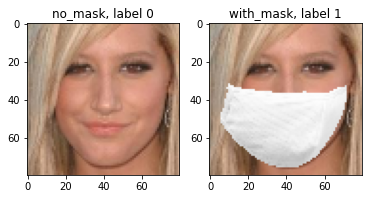

In [21]:
plt.subplot(1,2,1)

plt.imshow(img[:,:,::-1])
plt.title("no_mask, label 0")

if img_with_mask is not None:
    plt.subplot(1,2,2)
    plt.imshow(img_with_mask[:,:,::-1])
    plt.title("with_mask, label 1")
plt.show()

# 訓練集迭代資料函數

In [14]:
def get_ite_mask_data(paths,ite_num,batch_size):
    #----變數宣告
    ite_data = list()
    ite_label = list()
    qty = len(paths)
    
    num_start = batch_size * ite_num
    num_end = num_start + batch_size
    if num_end > qty:
        num_end = qty
    
    ite_paths = paths[num_start:num_end]
    
    for path in ite_paths:
        img = cv2.imread(path)
        if img is None:
            print("Read failed:{}".format(path))
        else:
            ite_data.append(img)
            ite_label.append(0)#沒戴口罩的label = 0

            img_with_mask = img_wear_mask(img,mask_paths,detector,predictor)
            if img_with_mask is not None:
                ite_data.append(img_with_mask)
                ite_label.append(1)#有戴口罩的label = 1
    #----串列轉換成ndarray
    ite_data = np.array(ite_data)
    ite_label = np.array(ite_label)
    
    #----資料標準化 normalization
    ite_data = ite_data.astype(np.float32)
    ite_data /= 255
    
    return ite_data,ite_label

(12, 80, 80, 3)
(12,)


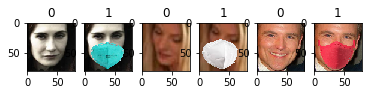

[0 1 0 1 0 1 0 1 0 1 0 1]


In [15]:
num= 6
ite_data,ite_label = get_ite_mask_data(train_paths,7,num)
print(ite_data.shape)
print(ite_label.shape)

for i in range(num):
    plt.subplot(1,num,i+1)
    plt.imshow(ite_data[i][:,:,::-1])
    plt.title(ite_label[i])
plt.show()
    

print(ite_label)

# 驗證集迭代資料函數

In [16]:
def get_ite_data(paths,ite_num,batch_size):
    #----變數宣告
    ite_data = list()
    ite_label = list()
    qty = len(paths)
    
    num_start = batch_size * ite_num
    num_end = num_start + batch_size
    if num_end > qty:
        num_end = qty
    ite_paths = paths[num_start:num_end]
    
    for path in ite_paths:
        img = cv2.imread(path)
        if img is None:
            print("Read failed:{}".format(path))
        else:
            ite_data.append(img)
            #----從資料夾名稱取得label
            classname = path.split("\\")[-2]
            label = classname2label_dict[classname]
            ite_label.append(label)
    #----串列轉換成ndarray
    ite_data = np.array(ite_data)
    ite_label = np.array(ite_label)
    
    #----資料標準化 normalization
    ite_data = ite_data.astype(np.float32)
    ite_data /= 255
    
    return ite_data,ite_label

# 建立計算圖 

In [17]:
graph_1 = tf.Graph()
activation = tf.nn.relu
save_dir = r"D:\code\model_saver\mask_classification_3"

In [18]:
with graph_1.as_default():
    #----建立tf.placeholder()，接收非張量型態的資料
    tf_input = tf.placeholder(tf.float32,shape=[None,80,80,3],name='input')
    tf_label = tf.placeholder(tf.int32,shape=[None],name="label")
    tf_keep_prob = tf.placeholder(tf.float32,name='keep_prob')

    #----建立類神經網路
    net = tf.layers.conv2d(
        inputs=tf_input,
        filters=8,
        kernel_size=[3, 3],
        padding="same",
        strides=1,
        activation=activation
    )
    print("卷積層 1 shape:",net.shape)

    net = tf.layers.max_pooling2d(net, pool_size=[2, 2], strides=2,padding='same')
    print("池化層 1 shape:",net.shape)

    net = tf.layers.conv2d(
        inputs=net,
        filters=16,
        kernel_size=[3, 3],
        padding="same",
        strides=1,
        activation=activation
    )
    print("卷積層 2 shape:",net.shape)

    net = tf.layers.max_pooling2d(net, pool_size=[2, 2], strides=2,padding='same')
    print("池化層 2 shape:",net.shape)

    net = tf.layers.conv2d(
        inputs=net,
        filters=32,
        kernel_size=[3, 3],
        padding="same",
        strides=1,
        activation=activation
    )
    print("卷積層 3 shape:",net.shape)

    net = tf.layers.max_pooling2d(net, pool_size=[2, 2], strides=2,padding='same')
    print("池化層 3 shape:",net.shape)

    net = tf.layers.flatten(net)
    print("陣列拉直後 shape:",net.shape)

    net = tf.layers.dense(inputs=net, units=64, activation=activation)
    print("全連接層 shape:",net.shape)

    net = tf.nn.dropout(net, keep_prob=tf_keep_prob)#加入dropout

    output = tf.layers.dense(inputs=net, units=2, activation=None)
    print("輸出層 shape:",output.shape)

    #----softmax函數輸出各類別的機率
    tf_prediction = tf.nn.softmax(output,name="prediction")

     #----設定損失函數
    tf_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_label,logits=output),
                      name="loss")

    #----設定最佳化函數
    learning_rate = 3e-4
    tf_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(tf_loss)

    #----設定儲存權重的資料夾
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    saver = tf.train.Saver(max_to_keep=5)

    #----GPU 資源設定
    config = tf.ConfigProto(log_device_placement=False,
                            allow_soft_placement=True)
    config.gpu_options.allow_growth = True

    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
卷積層 1 shape: (?, 80, 80, 8)
Instructions for updating:
Use keras.layers.max_pooling2d instead.
池化層 1 shape: (?, 40, 40, 8)
卷積層 2 shape: (?, 40, 40, 16)
池化層 2 shape: (?, 20, 20, 16)
卷積層 3 shape: (?, 20, 20, 32)
池化層 3 shape: (?, 10, 10, 32)
Instructions for updating:
Use keras.layers.flatten instead.
陣列拉直後 shape: (?, 3200)
Instructions for updating:
Use keras.layers.dense instead.
全連接層 shape: (?, 64)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
輸出層 shape: (?, 2)


# 計算損失值

In [19]:
def get_loss(paths,label_data,batch_size,sess):
    iterations =math.ceil(len(paths) / batch_size)
    loss = 0
    
    for iteration in range(iterations):
        ite_data,ite_label = get_ite_data(paths,iteration,batch_size)
        
        loss += sess.run(tf_loss,feed_dict={tf_input:ite_data,
                                            tf_label:ite_label,
                                            tf_keep_prob:1})
    
    loss /= iterations
    
    return loss

# 計算準確率函數

In [20]:
def get_accuracy(paths,batch_size,sess,use_dropout=False):
    iterations = math.ceil(len(paths)/ batch_size)
    correct_count = 0
    prediction_count = 0
    
    for iteration in range(iterations):
        ite_data,ite_label = get_ite_data(paths,iteration,batch_size)
        
        predictions = sess.run(tf_prediction,feed_dict={tf_input:ite_data,
                                                tf_keep_prob:1})
        
        arg_predictions = np.argmax(predictions,axis=1)
        for arg_prediction, label in zip(arg_predictions,ite_label):
            prediction_count += 1
            if arg_prediction == label:
                correct_count += 1
    acc = correct_count / prediction_count
    
    return acc

# 儲存PB檔案

In [21]:
def save_pb_file(graph,sess,tf_node_list,pb_save_path):
    graph = graph.as_graph_def()
#     graph = tf.get_default_graph().as_graph_def()
    output_graph_def = tf.graph_util.convert_variables_to_constants(sess, graph, tf_node_list)
    with gfile.GFile(pb_save_path, 'wb')as f:
        f.write(output_graph_def.SerializeToString())
    msg = "儲存pb檔至 {}".format(pb_save_path)
    print(msg)

# 訓練程式碼

In [22]:
batch_size=128
epochs=10
dropout_ratio=0.5  

In [23]:
acc_record = 0.97

#----計算迭代次數
iterations_train =math.ceil(qty_train_path / batch_size)
iterations_test = math.ceil(qty_test_path / batch_size)

#----宣告收集驗證集準確率的串列
loss_test_list = list()
acc_test_list = list()

#----載入上次的訓練權重檔案
weights_path = tf.train.latest_checkpoint(save_dir)
if weights_path is None:
    print("沒有之前的權重檔，重新訓練")
else:
    print("weights_path:",weights_path)
    try:
        saver.restore(sess, weights_path)
        print("使用之前的權重檔:{}".format(weights_path))   
    except:
        print("套用權重檔產生錯誤，重新訓練")

for epoch in range(epochs):
    #----record the time
    d_t = time.time()
    
    #----shuffle 只需將訓練集的順序打亂
    indice = np.random.permutation(qty_train_path)
    train_paths = train_paths[indice]

    for iteration in range(iterations_train):
        ite_data,ite_label = get_ite_mask_data(train_paths,iteration,batch_size)
        sess.run(tf_optimizer,feed_dict={tf_input:ite_data,
                                         tf_label:ite_label,
                                         tf_keep_prob:1-dropout_ratio})
            

    #----計算驗證集的準確率
    acc_test = get_accuracy(test_paths,batch_size,sess,use_dropout=True)
    loss_test = get_loss(test_paths, label_test,batch_size,sess)
                             
    #----record the time
    d_t = time.time() - d_t
    
    #----顯示驗證集準確率
    print("Epoch ",epoch)
    print("驗證集 損失值 = ",loss_test)
    print("驗證集 準確率 = ",acc_test)
    print("訓練週期使用時間:",d_t)

    #----收集驗證集數值至串列
    loss_test_list.append(float(loss_test))
    acc_test_list.append(float(acc_test))

    #----儲存權重檔案
    save_filename = os.path.join(save_dir,'model')
    model_save_path = saver.save(sess, save_filename, global_step=epoch)
    print("儲存權重檔至 {}".format(model_save_path))
    
    #----儲存準確率最高的PB檔案
    if acc_test > acc_record:
        pb_save_path = "infer_acc_{}.pb".format(acc_test)
        pb_save_path = os.path.join(save_dir,pb_save_path)
        save_pb_file(graph_1,sess,['prediction'],pb_save_path)
        acc_record = acc_test
        
    #----儲存訓練集與驗證集的損失值與準確率
    json_path = os.path.join(save_dir,'train_result.json')
    data_dict = {'acc_test_list':acc_test_list}
    with open(json_path,'w') as file_obj:
        json.dump(data_dict,file_obj)


沒有之前的權重檔，重新訓練
Epoch  0
驗證集 損失值 =  0.10100963546577933
驗證集 準確率 =  0.9793619565636693
訓練週期使用時間: 129.51562404632568
儲存權重檔至 D:\code\model_saver\mask_classification_3\model-0
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.
儲存pb檔至 D:\code\model_saver\mask_classification_3\infer_acc_0.9793619565636693.pb
Epoch  1
驗證集 損失值 =  0.04423102077321503
驗證集 準確率 =  0.986884234077846
訓練週期使用時間: 67.64386248588562
儲存權重檔至 D:\code\model_saver\mask_classification_3\model-1
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.
儲存pb檔至 D:\code\model_saver\mask_classification_3\infer_acc_0.986884234077846.pb
Epoch  2
驗證集 損失值 =  0.01686625941564774
驗證集 準確率 =  0.995486633491494
訓練週期使用時間: 67.57507491111755
儲存權重檔至 D:\code\model_saver\mask_classification_3\model-2
INFO:tensorflow:Froze 10

# 結果圖形化

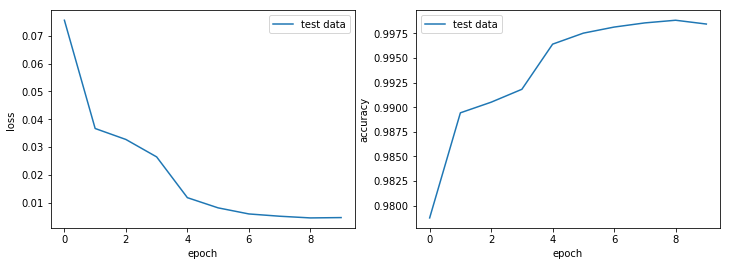

In [29]:
plt.figure(figsize=(12,4))#圖形的大小可以自行設定
x_num = [i for i in range(0,len(acc_test_list))]

plt.subplot(1,2,1)#設定第1張圖
# plt.plot(x_num,loss_train_list,label='train data')
plt.plot(x_num,loss_test_list,label='test data')
plt.xlabel("epoch")
plt.ylabel("loss ")
plt.legend()

plt.subplot(1,2,2)#設定第2張圖
# plt.plot(x_num,acc_train_list,label='train data')
plt.plot(x_num,acc_test_list,label='test data')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.show()#所有圖都設定完再執行show()